In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")
import matplotlib.pyplot as plt
from src.data.data_module import SegmentationDataModule
import torch
import numpy as np
import segmentation_models_pytorch as smp
from src.training.train_model import SegmentationModel
from src.training.models import DinoSegmentor
import lightning as L
from src.utils import deaugment_image
from src.callbacks import SaveStateDictCallback

In [3]:
import albumentations as A

train_augs = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # Normalize last (before converting to tensor)
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        A.ToTensorV2(),
    ]
)

tier1_dm = SegmentationDataModule(
    train_indices=["/workspace/data/new_processed//tier_1/train.csv"],
    val_indices=["/workspace/data/new_processed/tier_1/val.csv"],
    train_augs=train_augs,
    val_augs=train_augs,
    batch_size=4,
)

In [4]:
tier1_dm.setup()

In [5]:
for b in tier1_dm.train_dataloader():
    break

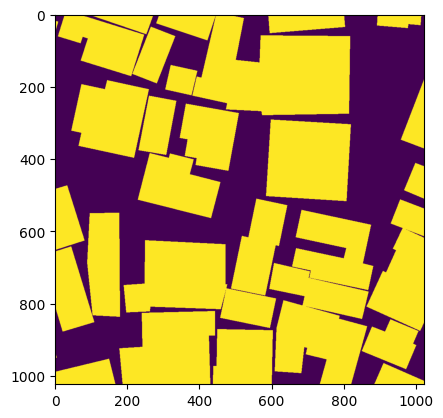

In [6]:
x, y = b
plt.imshow(y[0])

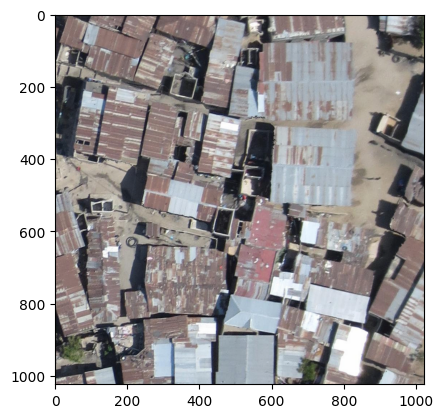

In [7]:
plt.imshow(deaugment_image(x[0]))

In [8]:
x.shape

torch.Size([4, 3, 1024, 1024])

In [9]:
ENCODER = "se_resnext50_32x4d"
ENCODER_WEIGHTS = "imagenet"
CLASSES = ["roof"]
ACTIVATION = None  # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = "cuda"

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=None,
).to(DEVICE)

# Custom U-Net Implementation

Now using our custom U-Net implementation that's compatible with smp.Unet interface

In [ ]:
from src.training.models.unet import Unet

ENCODER = "se_resnext50_32x4d"
ENCODER_WEIGHTS = "imagenet"
CLASSES = ["roof"]
ACTIVATION = None
DEVICE = "cuda"

# Create segmentation model with pretrained encoder (same interface as smp.Unet)
custom_model = Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
).to(DEVICE)

print(f"Model created with encoder: {ENCODER}")
print(f"Number of output classes: {len(CLASSES)}")

# Count parameters
num_params = sum(p.numel() for p in custom_model.parameters())
print(f"Total parameters: {num_params:,}")

In [ ]:
# Test the model with a sample batch
with torch.no_grad():
    custom_model.eval()
    test_output = custom_model(x.to(DEVICE))
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {test_output.shape}")
    print(
        f"Output range: [{test_output.min().item():.3f}, {test_output.max().item():.3f}]"
    )

## Alternative: Use with different encoders

You can easily swap encoders (ResNet18, ResNet50, ResNet101, ResNeXt, etc.)

In [ ]:
# Examples of other supported encoders:
#
# 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152'
# 'resnext50_32x4d', 'resnext101_32x8d', 'resnext101_64x4d'
# 'se_resnext50_32x4d' (requires timm: pip install timm)

# Example with ResNet50:
model_resnet50 = Unet(
    encoder_name="resnet50", encoder_weights="imagenet", classes=1, activation=None
).to(DEVICE)

# Example with ResNet18 (lighter model):
model_resnet18 = Unet(
    encoder_name="resnet18", encoder_weights="imagenet", classes=1, activation=None
).to(DEVICE)

print("✓ Multiple encoder options available!")

In [10]:
model = SegmentationModel(
    model=model,
    loss_fn=torch.nn.BCEWithLogitsLoss(),
    device=DEVICE,
)

In [11]:
# trainer = L.Trainer()
trainer = L.Trainer(
    precision="16",
    max_epochs=10,
    callbacks=[SaveStateDictCallback(save_dir="unet", prefix="unet_epoch")],
)

/opt/conda/envs/main_11/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/opt/conda/envs/main_11/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip 

In [12]:
trainer.fit(model, tier1_dm)

You are using a CUDA device ('NVIDIA GeForce RTX 5090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/main_11/lib/python3.11/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ Unet              │ 34.5 M │ train │     0 │
│ 1 │ loss_fn       │ BCEWithLogitsLoss │      0 │ train │     0 │
│ 2 │ train_metrics │ MetricCollection  │      0 │ train │     0 │
│ 3 │ val_metrics   │ MetricCollection  │      0 │ train │     0 │
│ 4 │ test_metrics  │ MetricCollection  │      0 │ train │     0 │
└───┴───────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 34.5 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 34.5 M                                                                                               
Total estimated model params size (MB): 138                                                                        
Modules in train mode: 331                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[SaveSMPStateDictCallback] Saved: unet/unet_epoch_000.pth

[SaveSMPStateDictCallback] Saved: unet/unet_epoch_001.pth

[SaveSMPStateDictCallback] Saved: unet/unet_epoch_002.pth

[SaveSMPStateDictCallback] Saved: unet/unet_epoch_003.pth

[SaveSMPStateDictCallback] Saved: unet/unet_epoch_004.pth

[SaveSMPStateDictCallback] Saved: unet/unet_epoch_005.pth

[SaveSMPStateDictCallback] Saved: unet/unet_epoch_006.pth

[SaveSMPStateDictCallback] Saved: unet/unet_epoch_007.pth

[SaveSMPStateDictCallback] Saved: unet/unet_epoch_008.pth

[SaveSMPStateDictCallback] Saved: unet/unet_epoch_009.pth

`Trainer.fit` stopped: `max_epochs=10` reached.


In [17]:
from pathlib import Path
import pandas as pd


def get_metrics(model_folder):
    metrics_log = []
    for model_pt in Path(model_folder).glob("*.pth"):
        model.model.load_state_dict(torch.load(model_pt))
        metrics = trainer.validate(model, tier1_dm)[0]
        metrics["model"] = model_pt.stem
        metrics_log.append(metrics)
    metrics_df = pd.DataFrame(metrics_log)
    metrics_df.to_csv(Path(model_folder) / "metrics.csv")
    return metrics_df


metrics_df = get_metrics("unet")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.5971149802207947     │
│       val_iou_epoch       │    0.4712226390838623     │
│         val_loss          │    0.17359554767608643    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.7584119439125061     │
│       val_iou_epoch       │    0.6426549553871155     │
│         val_loss          │    0.14767366647720337    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │     0.765370786190033     │
│       val_iou_epoch       │    0.6482806205749512     │
│         val_loss          │    0.13080589473247528    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.7712531089782715     │
│       val_iou_epoch       │     0.656894862651825     │
│         val_loss          │    0.12882626056671143    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.7696576714515686     │
│       val_iou_epoch       │    0.6542654633522034     │
│         val_loss          │    0.13447576761245728    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.7296583652496338     │
│       val_iou_epoch       │    0.6082970499992371     │
│         val_loss          │    0.14300404489040375    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.6980875730514526     │
│       val_iou_epoch       │    0.5741600394248962     │
│         val_loss          │    0.13762274384498596    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.7500147819519043     │
│       val_iou_epoch       │    0.6350841522216797     │
│         val_loss          │    0.15156684815883636    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.7742425799369812     │
│       val_iou_epoch       │    0.6601189374923706     │
│         val_loss          │    0.16114026308059692    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.7574953436851501     │
│       val_iou_epoch       │    0.6400631070137024     │
│         val_loss          │    0.13706250488758087    │
└───────────────────────────┴───────────────────────────┘